This code is referenced from <br>
https://colab.research.google.com/drive/1igoW8ryWYXDkcAExicaciFvHHFbscHDa

In this tutorial, we will introduce the use of MMpretrain with following content: <br>

1. get a pretrained model and test <br>
2. Prepare demo data <br>
3. Prepare the settings <br>
4. Train and test model <br>

In [2]:
import os
os.getcwd()

'/home/test/ml_sample/classification/MM'

In [7]:
cd mmpretrain

/home/test/MMdet/mmpretrain


# Download dataset and run
Download the dataset from https://data.mendeley.com/datasets/rscbjbr9sj/3 <br>
Put ZhangLabData under MMdet/mmpretrain/data <br>
We will use the OCT

In [23]:
from mmpretrain.apis import list_models
list_models(task='Image Classification', pattern='convnext')

['convnext-base_32xb128-noema_in1k',
 'convnext-base_32xb128_in1k',
 'convnext-base_3rdparty-noema_in1k',
 'convnext-base_3rdparty_in1k',
 'convnext-base_3rdparty_in1k-384px',
 'convnext-base_in21k-pre-3rdparty_in1k-384px',
 'convnext-base_in21k-pre_3rdparty_in1k',
 'convnext-large_3rdparty_in1k',
 'convnext-large_3rdparty_in1k-384px',
 'convnext-large_in21k-pre-3rdparty_in1k-384px',
 'convnext-large_in21k-pre_3rdparty_in1k',
 'convnext-small_32xb128-noema_in1k',
 'convnext-small_32xb128_in1k',
 'convnext-small_in21k-pre_3rdparty_in1k',
 'convnext-small_in21k-pre_3rdparty_in1k-384px',
 'convnext-tiny_32xb128-noema_in1k',
 'convnext-tiny_32xb128_in1k',
 'convnext-tiny_in21k-pre_3rdparty_in1k',
 'convnext-tiny_in21k-pre_3rdparty_in1k-384px',
 'convnext-v2-atto_fcmae-pre_3rdparty_in1k',
 'convnext-v2-base_fcmae-in21k-pre_3rdparty_in1k',
 'convnext-v2-base_fcmae-in21k-pre_3rdparty_in1k-384px',
 'convnext-v2-base_fcmae-pre_3rdparty_in1k',
 'convnext-v2-femto_fcmae-pre_3rdparty_in1k',
 'conv

In [4]:
# set configs for our model
# please revise the details inside for your task, take attention to #
# if you have no idea how to revise, just set %run tools/train.py configs/convnext_v2/convnext-v2-tiny_32xb32_in1k-384px.py first
# it will generate the used configs in work_dirs/
# then, you can copy the part that need to be revised and edit on it
# here, we change the num_classes, max_epochs, param_scheduler epoch, dataset_type, data_root, dropped split, topk

config = """
_base_ = [
    '../_base_/schedules/imagenet_bs1024_adamw_swin.py',
    '../_base_/default_runtime.py',
]

# model
model = dict(
    backbone=dict(
        arch='tiny',
        drop_path_rate=0.2,
        layer_scale_init_value=0.0,
        type='ConvNeXt',
        use_grn=True),
    head=dict(
        in_channels=768,
        init_cfg=None,
        loss=dict(label_smooth_val=0.2, type='LabelSmoothLoss'),
        num_classes=4,
        type='LinearClsHead'),
    init_cfg=dict(
        bias=0.0, layer=[
            'Conv2d',
            'Linear',
        ], std=0.02, type='TruncNormal'),
    train_cfg=dict(augments=[
        dict(alpha=0.8, type='Mixup'),
        dict(alpha=1.0, type='CutMix'),
    ]),
    type='ImageClassifier')
    
# schedule setting
optim_wrapper = dict(
    optimizer=dict(lr=3.2e-3),
    clip_grad=None,
)

# learning policy
param_scheduler = [
    # warm up learning rate scheduler
    dict(
        type='LinearLR',
        start_factor=1e-3,
        by_epoch=True,
        end=20,
        # update by iter
        convert_to_iter_based=True),
    # main learning rate scheduler
    dict(type='CosineAnnealingLR', eta_min=1e-5, by_epoch=True, begin=20)
]

# train, val, test setting
train_cfg = dict(by_epoch=True, max_epochs=150, val_interval=1)

# runtime setting
custom_hooks = [dict(type='EMAHook', momentum=1e-4, priority='ABOVE_NORMAL')]

# dataset settings
dataset_type = 'CustomDataset'
data_preprocessor = dict(
    num_classes=4,  # number of classes
    # RGB format normalization parameters
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    # convert image from BGR to RGB
    to_rgb=True,
)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='RandomResizedCrop',
        scale=384,
        backend='pillow',
        interpolation='bicubic'),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(type='PackInputs'),
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=384, backend='pillow', interpolation='bicubic'),
    dict(type='PackInputs'),
]

train_dataloader = dict(
    batch_size=48,
    num_workers=5,
    dataset=dict(
        type=dataset_type,
        data_root='data/ZhangLabData/CellData/OCT/train', # data directory
        pipeline=train_pipeline),
    sampler=dict(type='DefaultSampler', shuffle=True),
)

val_dataloader = dict(
    batch_size=48,
    num_workers=5,
    dataset=dict(
        type=dataset_type,
        data_root='data/ZhangLabData/CellData/OCT/test', # data directory
        pipeline=test_pipeline),
    sampler=dict(type='DefaultSampler', shuffle=False),
)
val_evaluator = dict(type='Accuracy', topk=(1))

# If you want standard test, please manually configure the test dataset
test_dataloader = val_dataloader
test_evaluator = val_evaluator
"""
# here we create the config file, you may rename it
with open('./configs/convnext_v2/convnext-v2-tiny_32xb32_in1k-384px_custom.py', 'w') as f:
    f.write(config)

In [6]:
%run tools/train.py configs/convnext_v2/convnext-v2-tiny_32xb32_in1k-384px_custom.py

04/23 13:11:13 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 268770812
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.8.0.dev20250422+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute

In [7]:
import torch
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Validation
set --out "your location to save a pkl"

In [10]:
%run tools/test.py work_dirs/convnext-v2-tiny_32xb32_in1k-384px_custom/20250423_131113/vis_data/config.py work_dirs/convnext-v2-tiny_32xb32_in1k-384px_custom/epoch_116.pth --out output/convnext-v2-tiny_32xb32_in1k-384px_custom.pkl

04/25 09:41:57 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 691983371
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.8.0.dev20250422+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute

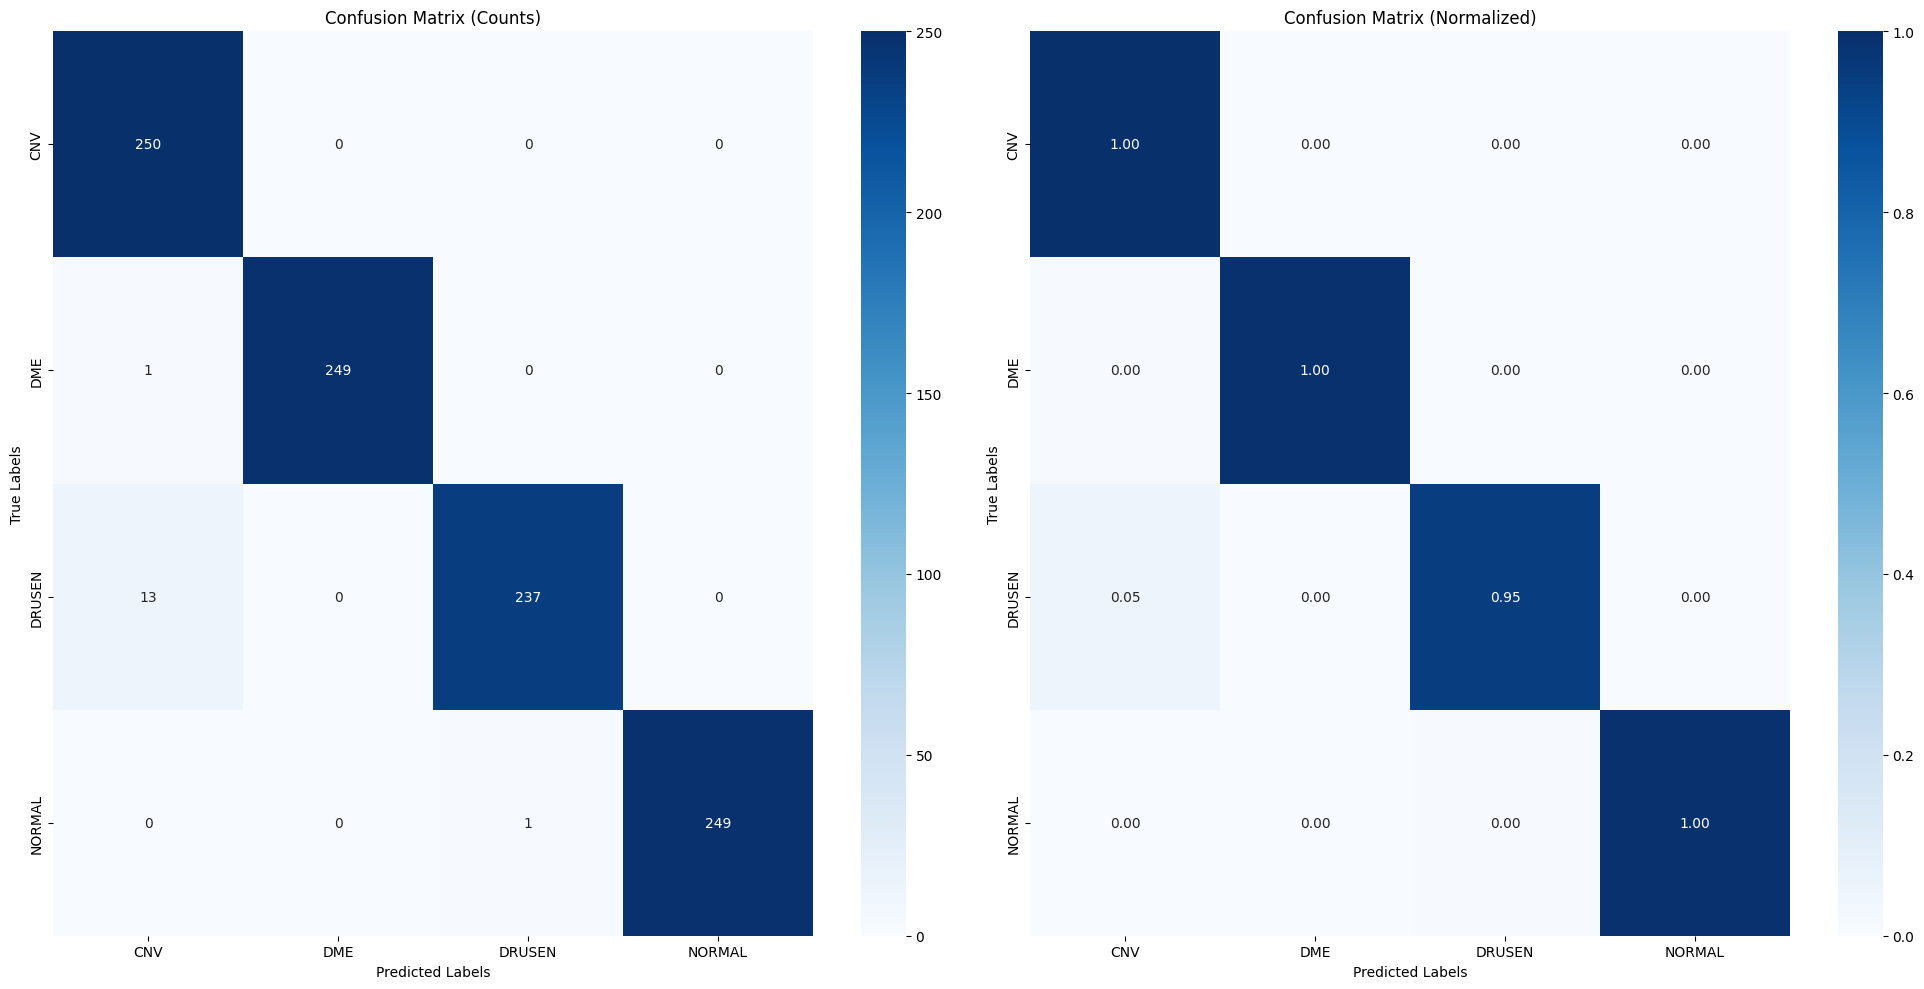

In [20]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# Load data from .pkl file
file_path = "output/convnext-v2-tiny_32xb32_in1k-384px_custom.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract ground truth and predicted labels
gt_labels = []
pred_labels = []

for entry in data:
    gt_labels.append(entry['gt_label'].item())  # Convert tensor to int
    pred_labels.append(entry['pred_label'].item())

# Define class names (replace with your actual class names)
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Compute confusion matrices
cm = confusion_matrix(gt_labels, pred_labels)
cm_normalized = confusion_matrix(gt_labels, pred_labels, normalize='true')  # Normalized by true labels

# Plot standard confusion matrix
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Counts)')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()